In [29]:
'''Importing all necessary libraries'''

import requests
import threading
import dask.array as da
import numpy as np
import h5py
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import TensorDataset, DataLoader, Subset
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import random_split
import os
import warnings
import io

In [4]:
url_e = "https://cernbox.cern.ch/remote.php/dav/public-files/FbXw3V4XNyYB3oA/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5"
file_e = "electron.h5"

url_p = "https://cernbox.cern.ch/remote.php/dav/public-files/AtBT8y4MiQYFcgc/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5"
file_p = "photon.h5"

def download_file(url, filename):
    response = requests.get(url, stream=True)
    with open(filename, "wb") as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)
    print(f"Downloaded {filename}")

t1 = threading.Thread(target=download_file, args=(url_e, file_e))
t2 = threading.Thread(target=download_file, args=(url_p, file_p))

t1.start()
t2.start()
t1.join()
t2.join()

file_e = h5py.File('electron.h5', 'r')
file_p = h5py.File('photon.h5', 'r')

X_e = da.from_array(file_e['X'], chunks=(1000, 32, 32,2))
X_p = da.from_array(file_p['X'], chunks=(1000, 32, 32,2))
y_e = da.from_array(file_e['y'], chunks=1000)
y_p = da.from_array(file_p['y'], chunks=1000)

X = da.concatenate([X_e, X_p])
y = da.concatenate([y_e, y_p])

print(f"Total X set shape: {X.shape}")
print(f"Total y set shape: {y.shape}")

Downloaded photon.h5
Downloaded electron.h5
Total X set shape: (498000, 32, 32, 2)
Total y set shape: (498000,)


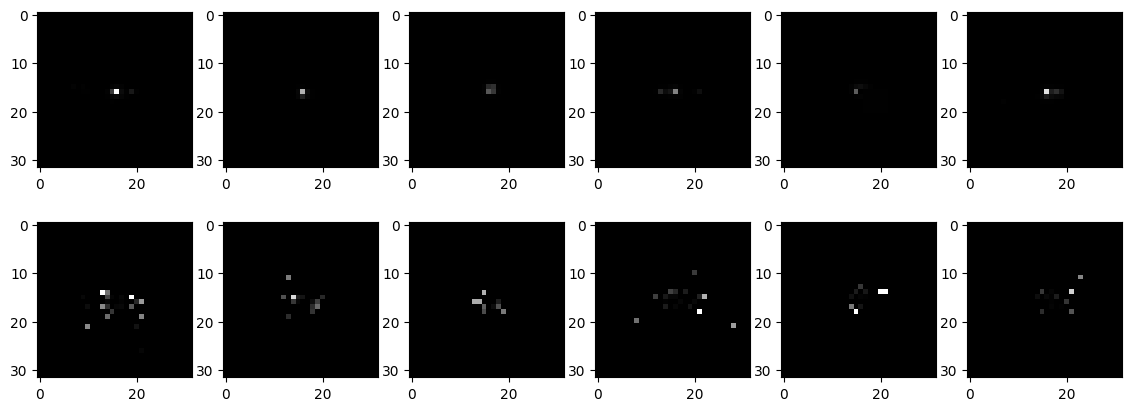

In [5]:
'''Sample Electron data. The top and bottom rows plot channel 1 and 2 respectively.'''

fig, axes = plt.subplots(2, 6, figsize=(14, 5))
for i in range(2):
    for j in range(6):
        ax = axes[i][j]
        im = ax.imshow(X_e[j][:,:,i], cmap = 'gray', vmin=0, vmax=1)
plt.show()

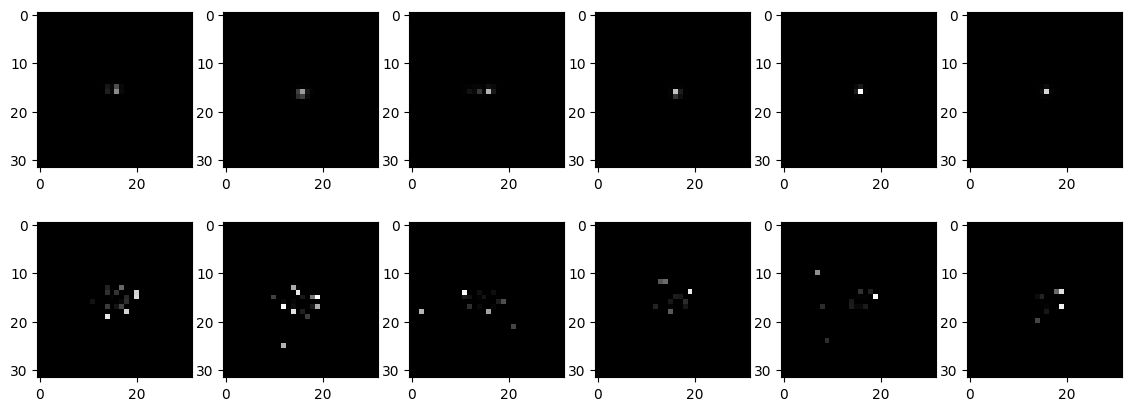

In [6]:
'''Sample photon data. The top and bottom rows plot channel 1 and 2 respectively.'''

fig, axes = plt.subplots(2, 6, figsize=(14, 5))
for i in range(2):
    for j in range(6):
        ax = axes[i][j]
        im = ax.imshow(X_p[j][:,:,i], cmap = 'gray', vmin=0, vmax=1)
plt.show()

In [7]:
'''Splitting the dataset into testing and training dataset.'''

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=83)
print(f"X_train.shape = {X_train.shape}, y_train.shape= {y_train.shape}")
print(f"X_test.shape = {X_test.shape}, y_test.shape =  {y_test.shape}")

'''Creating the data loaders.'''


def data_loaders(train_dataset,
                 test_dataset,
                 batch_size,
                 shuffle = True,
                 num_workers = 4, 
                 pin_memory = False):
    train_loader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size = batch_size,
              
                                               shuffle = shuffle,
                                               num_workers = num_workers,
                                               pin_memory = pin_memory)
    test_loader = torch.utils.data.DataLoader(test_dataset, 
                                            batch_size = batch_size,
                                            shuffle = shuffle,
                                            num_workers = num_workers, 
                                            pin_memory = pin_memory)

    return (train_loader, test_loader)

X_train_numpy = X_train.compute()
y_train_numpy = y_train.compute()

X_train_tensor = torch.tensor(X_train_numpy, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_numpy, dtype=torch.long)

X_test_numpy = X_test.compute()
y_test_numpy = y_test.compute()

X_test_tensor = torch.tensor(X_test_numpy, dtype = torch.float32)
y_test_tensor = torch.tensor(y_test_numpy, dtype = torch.long)

X_train_tensor = X_train_tensor.permute(0, 3, 1, 2)
X_test_tensor = X_test_tensor.permute(0, 3, 1, 2)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

X_train.shape = (398400, 32, 32, 2), y_train.shape= (398400,)
X_test.shape = (99600, 32, 32, 2), y_test.shape =  (99600,)


In [8]:
'''Defining the ResNet architecture.'''


class block(nn.Module):
    def __init__(self, channels, subsample):
        super().__init__()
        if subsample: 
            self.conv1 = nn.Conv2d(channels//2, 
                                   channels, 
                                   kernel_size=3, 
                                   stride = 2,
                                   padding = 1,
                                   bias=False)
        else:
            self.conv1 = nn.Conv2d(channels,
                                   channels,
                                   kernel_size = 3,
                                   stride = 1,
                                   padding = 1,
                                   bias = False)
            
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(channels, 
                               channels, 
                               kernel_size = 3,
                               stride = 1, 
                               padding = 1,
                               bias = False)
        self.bn2 = nn.BatchNorm2d(channels)
        self.relu2 = nn.ReLU()
        self.maxp = nn.MaxPool2d(kernel_size = 2,
                                 stride = 2,
                                 padding = 0)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, 
                                        mode = 'fan_out', 
                                        nonlinearity = 'relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def shortcut(self, inpt, outpt):
        #outpt: final block prior to nonlinearity

        if(inpt.shape!= outpt.shape):
            downsample = self.maxp(inpt)
            zero_tensor = torch.mul(downsample, 0)
            return torch.cat((downsample, zero_tensor), dim = 1) + outpt
        else:
            return inpt+outpt

    def forward(self, inpt):
        outpt = self.conv1(inpt)
        outpt = self.bn1(outpt)
        outpt = self.relu1(outpt)
        outpt = self.conv2(outpt)
        outpt = self.bn2(outpt)
        outpt = self.shortcut(inpt, outpt)
        outpt = self.relu2(outpt)
        return outpt


class resnet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_inpt = nn.Conv2d(2, 
                                  16,
                                  kernel_size = 3,
                                  stride = 1,
                                  padding = 1,
                                  bias = False)
        self.bn_inpt = nn.BatchNorm2d(16)
        self.relu_inpt = nn.ReLU()
        self.maxp_inpt = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        #block-set 1
        self.set1 = nn.ModuleList([block(16, subsample = False) for _ in range(1)])

        #block-set2
        self.set2a = block(32, subsample = True)
        self.set2b = nn.ModuleList([block(32, subsample = False) for _ in range(1)])

        #block-set3
        self.set3a = block(64, subsample = True)
        self.set3b = nn.ModuleList([block(64, subsample = False) for _ in range(2)])

        #block-set3
        self.set4a = block(128, subsample = True)

        self.avgpool = nn.AvgPool2d(kernel_size =2, stride = 2)
        self.fc = nn.Linear(256, 2, bias = True)
        self.dropout_fc = nn.Dropout(p=0.5)
        self.softmax = nn.LogSoftmax(dim = -1)

        for m in self.modules():
            if isinstance(m,nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                m.bias.data.zero_()

    def forward(self, inpt):
        outpt = self.conv_inpt(inpt)
        outpt = self.bn_inpt(outpt)
        outpt = self.relu_inpt(outpt)
        outpt = self.maxp_inpt(outpt)
        
        for layer in self.set1:
            outpt = layer(outpt)

        outpt = self.set2a(outpt)
        for layer in self.set2b:
            outpt = layer(outpt)

        outpt = self.set3a(outpt)
        for layer in self.set3b:
            outpt = layer(outpt)

        outpt = self.avgpool(outpt)
        outpt = outpt.reshape(outpt.size(0), -1)
        outpt = self.fc(outpt)
        outpt = self.dropout_fc(outpt)
        return self.softmax(outpt)
            

In [9]:
'''Defining training and evaluation functions.'''


def evaluate(model, data_loader, device):
    y_true = np.array([], dtype =int)
    y_pred = np.array([], dtype = int)
    model.eval()
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            y_true = np.concatenate((y_true, labels.cpu()))
            y_pred = np.concatenate((y_pred, predicted.cpu()))

    error = np.sum(y_pred!=y_true)/len(y_true)
    return error

def train(model, epochs, train_loader, test_loader, criterion, optimizer, results_path,
          scheduler = None, model_path = None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)
    model.to(device)

    cols       = ['epoch', 'train_loss', 'train_err', 'test_err']
    results_df = pd.DataFrame(columns=cols).set_index('epoch')
    
    for epoch in range(epochs):
        
        model.train()
        running_loss  = 0.0
        best_test_err = 1.0
        for i, data in enumerate(train_loader, 0):
            
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            if i % 50 == 49:
                running_loss = 0.0
        
        if scheduler:
            scheduler.step()
        
        model.eval()
        train_loss = loss.item()
        train_err = evaluate(model, train_loader, device)
        test_err = evaluate(model, test_loader, device)
        results_df.loc[epoch] = [train_loss, train_err, test_err]
        results_df.to_csv(results_path)
        print(f'epoch:{epoch} | train_err: {train_err:.4f} | test_err: {test_err:.4f}')
        
        if model_path and (test_err < best_test_err):
            torch.save(model.state_dict(), model_path)
            best_test_err = test_err
        
        
    print('Finished Training')
    model.eval()
    return model

In [10]:
'''Hyperparameters'''

lr = 0.006
weight_decay = 0.00036
gamma = 0.2722

In [11]:
'''Normalization helps when classifying MNIST of CIFAR datasets. 
    But does it help with the classifcation task at hand?
    We can check the accuracy for a sample dataset with and without normalization.
    
    Defining the function to find normaliation parameteres.'''

def normalization_params(train_loader):
    sum_chan0, sum_chan1 = 0, 0
    sum_sq_chan0, sum_sq_chan1 = 0, 0
    total_pixels = 0

    for matrix, _ in train_loader:
        chan0 = matrix[:, 0, :, :] 
        chan1 = matrix[:, 1, :, :]

        sum_chan0 += chan0.sum().item()
        sum_chan1 += chan1.sum().item()
        sum_sq_chan0 += (chan0 ** 2).sum().item()
        sum_sq_chan1 += (chan1 ** 2).sum().item()

        total_pixels += chan0.numel()

    mean0 = sum_chan0 / total_pixels
    mean1 = sum_chan1 / total_pixels

    std0 = ((sum_sq_chan0 / total_pixels) - mean0**2) ** 0.5
    std1 = ((sum_sq_chan1 / total_pixels) - mean1**2) ** 0.5

    return [mean0, mean1], [std0, std1]

In [12]:
'''Using 25% of the dataset for testing if normalization helps.'''


train_set = list(zip(X_train_numpy, y_train_numpy))
test_set = list(zip(X_test_numpy, y_test_numpy))

_, train_set_optim = train_test_split(train_set, test_size=0.25, random_state=42)
_, test_set_optim = train_test_split(test_set, test_size=0.25, random_state=42)

train_set_optim = [(torch.tensor(x, dtype=torch.float32), torch.tensor(int(y), dtype=torch.long)) 
                   for x, y in train_set_optim]

test_set_optim = [(torch.tensor(x, dtype=torch.float32), torch.tensor(int(y), dtype=torch.long)) 
                  for x, y in test_set_optim]

print("Train Optim Size:", len(train_set_optim))
print("Test Optim Size:", len(test_set_optim))

Train Optim Size: 99600
Test Optim Size: 24900


In [13]:
'''Training WITHOUT normalization.'''


batch_size = 150

train_loader = DataLoader(train_set_optim, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set_optim, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet().to(device)

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[], gamma=gamma)
criterion = torch.nn.NLLLoss()

criterion = criterion.to(device)

for epoch in range(10):
    model.train()
    for inputs, labels in train_loader:
        inputs = inputs.permute(0, 3, 1, 2)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.permute(0, 3, 1, 2)
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"Accuracy on validation set without normalization: {100*accuracy:.4f}%")

Accuracy on validation set without normalization: 64.7590%


In [14]:
'''Training WITH normalization'''

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet().to(device)

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[], gamma=gamma)
criterion = torch.nn.NLLLoss()

criterion = criterion.to(device)

means, stds = normalization_params(train_loader)
normalize = transforms.Normalize(mean=means, std=stds)

for epoch in range(10):
    model.train()
    for inputs, labels in train_loader:
        inputs = inputs.permute(0, 3, 1, 2)
        inputs = normalize(inputs)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.permute(0, 3, 1, 2)
        inputs = normalize(inputs)
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"Accuracy on validation set with normalization: {100*accuracy:.4f}%")


Accuracy on validation set with normalization: 63.8514%


In [19]:
'''We can see that normalization does NOT help. Accuracy for training WITHOUT normalization is better than WITH normalization than almost 1%. 
    Training on the entire dataset with normalization.'''

batch_size = 640

train_loader, test_loader = data_loaders(train_dataset,
                                        test_dataset,
                                         batch_size,
                                         shuffle = True,
                                         num_workers = 4,
                                         pin_memory = True)

milestones= [51, 77]

iterations = 0
for i, data in enumerate(train_loader, 0):
    iterations+=1

results_dir = "results"
model_dir = "trained"

os.makedirs(results_dir, exist_ok = True)
os.makedirs(model_dir, exist_ok = True)

results_file = os.path.join(results_dir, "resnet15.csv")
model_file = os.path.join(model_dir, "resnet15.pt")
results_df = pd.DataFrame(columns=["epoch", "train_loss", "train_err", "test_err"])

results_df.to_csv(results_file)

warnings.filterwarnings("ignore")
epochs= 37

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet().to(device)

optimizer = optim.SGD(model.parameters(), 
                       lr=lr, 
                       weight_decay=weight_decay, 
                     momentum = 0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, 
                                           milestones, 
                                           gamma=gamma)
criterion = torch.nn.NLLLoss()
criterion = criterion.to(device)

results_file = f'results/resnet15.cvs'
model_file = f'trained/resnet15.pt'
train(model, 
      epochs, 
      train_loader, 
      test_loader, 
      criterion,
      optimizer,
      results_file, 
      scheduler = scheduler,
      model_path = model_file)

cuda
epoch:0 | train_err: 0.4238 | test_err: 0.4229
epoch:1 | train_err: 0.4146 | test_err: 0.4193
epoch:2 | train_err: 0.3633 | test_err: 0.3658
epoch:3 | train_err: 0.3537 | test_err: 0.3572
epoch:4 | train_err: 0.3503 | test_err: 0.3514
epoch:5 | train_err: 0.3528 | test_err: 0.3559
epoch:6 | train_err: 0.3290 | test_err: 0.3297
epoch:7 | train_err: 0.3365 | test_err: 0.3413
epoch:8 | train_err: 0.3045 | test_err: 0.3064
epoch:9 | train_err: 0.3323 | test_err: 0.3346
epoch:10 | train_err: 0.3542 | test_err: 0.3549
epoch:11 | train_err: 0.2908 | test_err: 0.2934
epoch:12 | train_err: 0.3014 | test_err: 0.3046
epoch:13 | train_err: 0.3374 | test_err: 0.3415
epoch:14 | train_err: 0.3370 | test_err: 0.3413
epoch:15 | train_err: 0.2946 | test_err: 0.2978
epoch:16 | train_err: 0.2810 | test_err: 0.2848
epoch:17 | train_err: 0.2826 | test_err: 0.2855
epoch:18 | train_err: 0.2807 | test_err: 0.2820
epoch:19 | train_err: 0.2913 | test_err: 0.2933
epoch:20 | train_err: 0.2844 | test_err: 0.28

resnet(
  (conv_inpt): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn_inpt): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_inpt): ReLU()
  (maxp_inpt): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (set1): ModuleList(
    (0): block(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU()
      (maxp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (set2a): block(
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e

In [21]:
model_path = "/kaggle/working/trained/resnet15.pt"
model.load_state_dict(torch.load(model_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
model.eval()
print("Model loaded successfully!")

Model loaded successfully!


In [22]:
'''Checking the accuracy on test dataset'''

correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"Accuracy on validation set with normalization: {100*accuracy:.4f}%")

Accuracy on validation set with normalization: 71.6004%


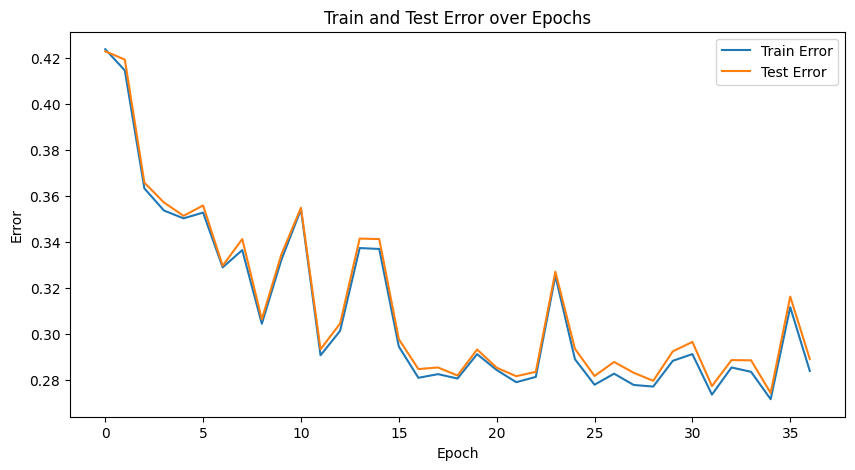

In [30]:
data = """epoch,train_err,test_err
0,0.4238,0.4229
1,0.4146,0.4193
2,0.3633,0.3658
3,0.3537,0.3572
4,0.3503,0.3514
5,0.3528,0.3559
6,0.3290,0.3297
7,0.3365,0.3413
8,0.3045,0.3064
9,0.3323,0.3346
10,0.3542,0.3549
11,0.2908,0.2934
12,0.3014,0.3046
13,0.3374,0.3415
14,0.3370,0.3413
15,0.2946,0.2978
16,0.2810,0.2848
17,0.2826,0.2855
18,0.2807,0.2820
19,0.2913,0.2933
20,0.2844,0.2854
21,0.2791,0.2817
22,0.2814,0.2836
23,0.3253,0.3271
24,0.2891,0.2936
25,0.2780,0.2818
26,0.2828,0.2879
27,0.2779,0.2832
28,0.2772,0.2797
29,0.2884,0.2925
30,0.2913,0.2966
31,0.2737,0.2774
32,0.2855,0.2887
33,0.2836,0.2886
34,0.2717,0.2744
35,0.3117,0.3163
36,0.2840,0.2892"""

df = pd.read_csv(io.StringIO(data))

plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['train_err'], label='Train Error')
plt.plot(df['epoch'], df['test_err'], label='Test Error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Train and Test Error over Epochs')
plt.legend()
plt.show()
